In [9]:
# Kullanılacak kütüphaneler
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing import image


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [10]:
# Veriyi yükleme fonksiyonu
def load_data(train_dir, test_dir):
    # Görüntüleri yeniden ölçeklendirmek için bir ImageDataGenerator oluşturuyoruz
    datagen = ImageDataGenerator(rescale=1./255)
    
    # Eğitim verilerimizi yüklemek ve ön işlemleri gerçekleştirmek için bir generator oluşturuyoruz
    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')
    
    # Test verilerimizi yüklemek ve ön işlemleri gerçekleştirmek için bir generator oluşturuyoruz
    test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')
    
    # Generatorları döndürüyoruz
    return train_generator, test_generator

In [11]:
# Veriyi yükleme
train_dir = '/kaggle/input/brain-tumor-classification-mri/Training'
test_dir = '/kaggle/input/brain-tumor-classification-mri/Testing'
train_gen, test_gen = load_data(train_dir, test_dir)

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [12]:
# Model oluşturma fonksiyonu
def create_model():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(4, activation='softmax'))
    
    # Modeli döndürüyoruz
    return model

In [13]:
# Model oluşturma
model = create_model()

In [14]:
# Modeli compile ediyoruz. Loss fonksiyonu olarak categorical_crossentropy kullanıyoruz çünkü çoklu sınıflandırma problemimiz var.
# Optimizasyon algoritması olarak Adam'ı kullanıyoruz. Metrik olarak accuracy'yi kullanıyoruz.
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
# Callbacks tanımlıyoruz. Bunlar modelin eğitimi sırasında belirli durumlarda gerçekleşecek işlemleri belirler
# ModelCheckpoint, her epoch sonunda modelin ağırlıklarını kaydeder. Böylece en iyi modeli kaybetmeyiz
# EarlyStopping, belirli bir sayıda epoch boyunca modelin performansının artmaması durumunda eğitimi durdurur

checkpoint = ModelCheckpoint("brain_tumor_detector.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=100, verbose=1, mode='auto')

In [16]:
# Modeli fit ediyoruz. Yani modeli eğitiyoruz. Eğitim verilerini ve doğrulama verilerini belirtiyoruz. Epoch sayısını ve callbacks'ları belirtiyoruz.
history = model.fit(train_gen, epochs=10, validation_data=test_gen, callbacks=[checkpoint,early])

Epoch 1/10
90/90 [==============================] - ETA: 0s - loss: 0.9826 - accuracy: 0.6017
Epoch 1: val_accuracy improved from -inf to 0.43655, saving model to brain_tumor_detector.h5
90/90 [==============================] - 24s 193ms/step - loss: 0.9826 - accuracy: 0.6017 - val_loss: 2.1110 - val_accuracy: 0.4365
Epoch 2/10
90/90 [==============================] - ETA: 0s - loss: 0.5526 - accuracy: 0.7676
Epoch 2: val_accuracy improved from 0.43655 to 0.54315, saving model to brain_tumor_detector.h5
90/90 [==============================] - 9s 99ms/step - loss: 0.5526 - accuracy: 0.7676 - val_loss: 2.0396 - val_accuracy: 0.5431
Epoch 3/10
90/90 [==============================] - ETA: 0s - loss: 0.3919 - accuracy: 0.8429
Epoch 3: val_accuracy improved from 0.54315 to 0.60660, saving model to brain_tumor_detector.h5
90/90 [==============================] - 9s 103ms/step - loss: 0.3919 - accuracy: 0.8429 - val_loss: 2.2500 - val_accuracy: 0.6066
Epoch 4/10
90/90 [======================

In [17]:
# Modeli değerlendiriyoruz
test_steps = test_gen.n // test_gen.batch_size
loss, accuracy = model.evaluate(test_gen, steps=test_steps)
print('Test accuracy: ', accuracy)

test_gen.reset()
Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_gen.classes, y_pred))

print('Classification Report')
target_names = list(test_gen.class_indices.keys())
print(classification_report(test_gen.classes, y_pred, target_names=target_names))

12/12 [==============================] - 1s 81ms/step - loss: 5.6108 - accuracy: 0.7031
Test accuracy:  0.703125
13/13 [==============================] - 1s 87ms/step
Confusion Matrix
[[ 8 43 41  8]
 [ 5 49 50 11]
 [ 4 45 42 14]
 [ 1 33 33  7]]
Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       0.44      0.08      0.14       100
meningioma_tumor       0.29      0.43      0.34       115
        no_tumor       0.25      0.40      0.31       105
 pituitary_tumor       0.17      0.09      0.12        74

        accuracy                           0.27       394
       macro avg       0.29      0.25      0.23       394
    weighted avg       0.30      0.27      0.24       394



1/1 [==============================] - 0s 122ms/step


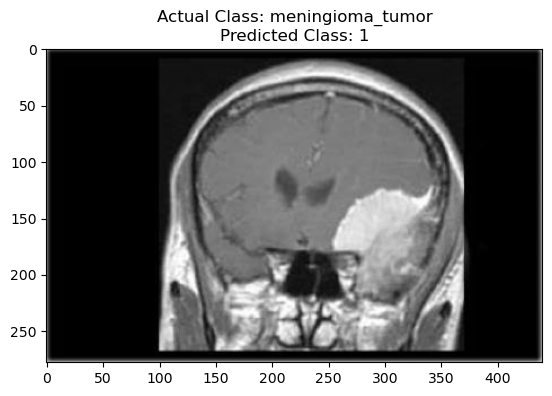

In [18]:
# Bir adet fotoğrafı test ediyoruz
import os
from PIL import Image
import matplotlib.pyplot as plt

def test_image(file_path, model):
    img = Image.open(file_path).resize((150, 150))
    img_array = np.array(img)/255.0  # We also normalize the image values as we did before
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    
    actual_class = os.path.basename(os.path.dirname(file_path))

    img = Image.open(file_path)
    plt.imshow(img)
    plt.title(f"Actual Class: {actual_class}\nPredicted Class: {predicted_class}")
    plt.show()


test_image("/kaggle/input/brain-tumor-classification-mri/Testing/meningioma_tumor/image(1).jpg", model)

In [22]:
test_gen.class_indices

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}